# Cleaning up our Midterm Notebooks

**_Arturo Jacobo and Miranda Mead-Newton_**

Week 7 Assignment, cleaning up our midterm. 

In [1]:
# libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import osmnx as ox

## Commuter Data by Mode for the City of LA

We'll start by analyzing census data for commute modes by census tract for the City of LA. We are using a dataset from American Community Survey 2019. We're saving the dataset as a variable and then cleaning the dataset for use. 

In [2]:
tr = gpd.read_file('data/acs2019_5yr_B08134_14000US06037185320.geojson')

We have to drop the last row of data which is a total of all of the data for the City of LA. 

In [3]:
tr=tr.drop([1004])

Next, we'll keep only the columns we will need for analysis. We'll be analyzing just the commuter modes for bus and private vehicles. 

In [4]:
columns_to_keep = ['geoid',
                  'name',
                  'B08134001',
                  'B08134021',
                  'B08134022',
                  'B08134023',
                  'B08134024',
                  'B08134025',
                  'B08134026',
                  'B08134027',
                  'B08134028',
                  'B08134029',
                  'B08134030',
                  'B08134071',
                  'B08134072',
                  'B08134073',
                   'B08134074',
                   'B08134075',
                  'B08134076',
                  'B08134077',
                  'B08134078',
                  'B08134079',
                  'B08134080',
                  'geometry']

In [5]:
tr = tr[columns_to_keep]

Below, we rename the columns. `Drove_Solo` is the number of people in each tract who drive to work and `Bus` is number of people who take the bus to work. Then, there is a breakdown by commute time. `D_lt_10` is the number of people who drove who had a commute of less than 10 minutes. `B_25_29` is commute time for bus that was 25-29 minutes. 

In [6]:
tr.columns = ['geoid',
 'name',
 'Total',
 'Drove_Solo',
 'D_lt_10',
 'D_10_14',
 'D_15_19',
 'D_20_24',
 'D_25_29',
 'D_30_34',
 'D_35_44',
 'D_45_59',
 'D_60_om',
 'Bus',
 'B_lt_10',
 'B_10_14',
 'B_15_19',
 'B_20_24',
 'B_25_29',
 'B_30_34',
 'B_35_44',
 'B_45_59',
 'B_60_om',
 'geometry']

Since it's not as useful to look at raw totals, we will want to have a percent of the census tract by mode share. Our data omits other modes so they will not add up to 100 in a tract. 

In [7]:
# create a new column and populate it with normalized data to get the percent of total value
# we are creating new variables
tr['Percent_D_Solo'] = tr['Drove_Solo']/tr['Total']*100
tr['Percent_Bus']= tr['Bus']/tr['Total']*100

Next, we'll visualize our data graphically using plotly.

In [8]:
tr_1 = pd.DataFrame.from_records(tr)

This creates a dataframe that can be read by plotly.

In [9]:
x0 = tr_1['Percent_D_Solo']
x1 = tr_1['Percent_Bus']

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=x0,
    histnorm='percent',
    name='Percent of CT that drive to work', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=0,
        end=100,
        size=1
    ),
    marker_color='#EB89B5',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=x1,
    histnorm='percent',
    name='Percent of CT that take the bus',
    xbins=dict(
        start=0,
        end=100,
        size=1
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Sampled Results', # title of plot
    xaxis_title_text='Percent', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

This histogram shows the distribution of modes for each census tract in LA. The purple lines are frequencies of the percent of a census tract that takes the bus in the morning and the pink lines represent the frequency of different percentages of a census tract that commute by car. For example, we can see that in 13 of the census tracts in LA, only 1% of the population takes the bus to work. Further along the x-axis, we see that as the percentage increases, bus ridership decreases and vehicle ridership increases. Only 4 census tracts have a majority of bus riders and most census tracts are made up of a large majority of drivers. 

Next we'll spatially visualize the data. 

Text(0.5, 1.0, 'Percentage of Car Drivers by Census Tract')

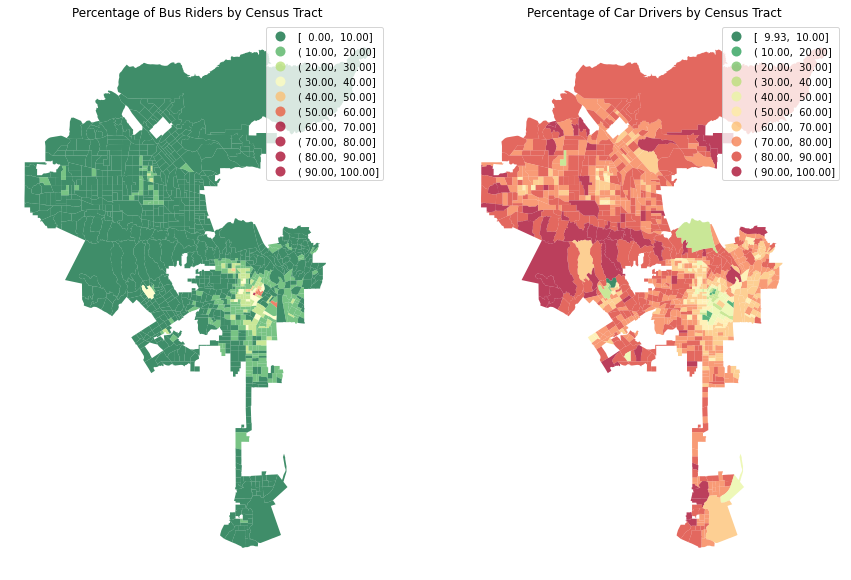

In [10]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
tr.plot(column='Percent_Bus', 
            cmap='RdYlGn_r', scheme='user_defined', 
         classification_kwds={'bins':[10,20,30,40,50,60,70,80,90,100]},
            
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Percentage of Bus Riders by Census Tract")

# spatial lag map on the right
tr.plot(column='Percent_D_Solo', 
            cmap='RdYlGn_r', 
            scheme='user_defined', 
         classification_kwds={'bins':[10,20,30,40,50,60,70,80,90,100]},
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot
            legend=True
           )

ax2.axis("off")
ax2.set_title("Percentage of Car Drivers by Census Tract")

Fitting with our graph, we can see that a majority of LA drives to work. The census tracts with high bus ridership are concentrated in the center of the city, near downtown as well as in Westwood and South LA. 

Below, we added a basemap and examine the census tracts with greater than 20% of the population who take the bus. 

In [11]:
# reproject to Web Mercator
tr_web_mercator = tr.to_crs(epsg=3857)

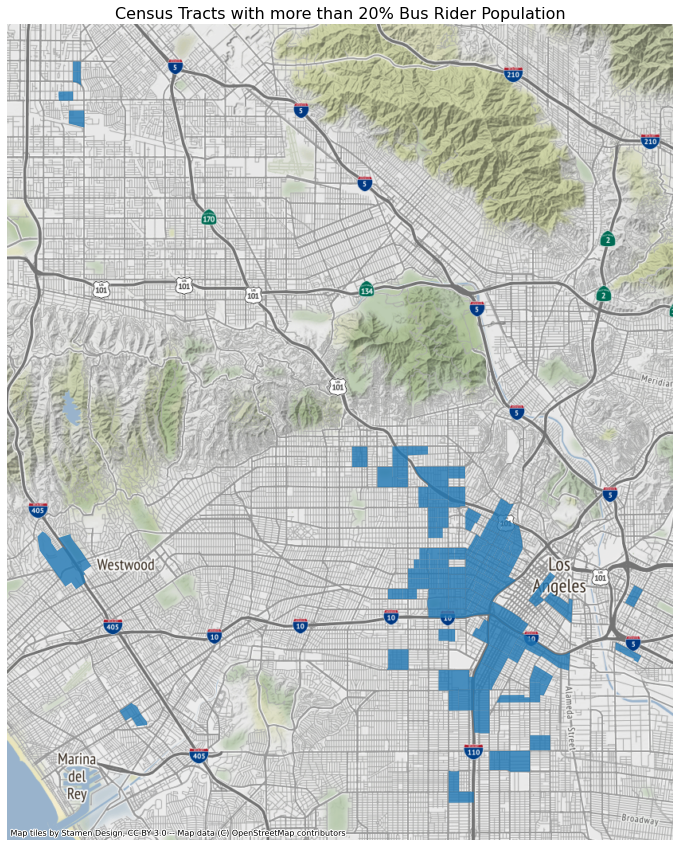

In [12]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# add the layer with ax=ax in the argument 
tr_web_mercator[tr_web_mercator['Percent_Bus'] > 20].plot(ax=ax, alpha=0.8)

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Census Tracts with more than 20% Bus Rider Population',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

This is a slightly more zoomed in look at what we could see overall for the City. The bus ridership population is concentrated near downtown and south of downtown with some higher ridership numbers in Westwood and in the Valley. 

We want to explore the relationship between bus ridership data and census tract median income. 

## Income Data for the City of LA

For income data, we're also using an ACS dataset from 2019 from Census Explorer. 

In [13]:
income = gpd.read_file('data/acs2019_5yr_B19013_14000US06037185320.geojson')

In [14]:
#cleaning up the dataset
columns_to_keep = ['geoid','name','B19013001','geometry']
income = income[columns_to_keep]
income.columns = ['geoid', 'name', 'median income', 'geometry']
income = income.drop([1004])

We'll map the income data for the City of LA so that we can compare it to commuter mode data. 

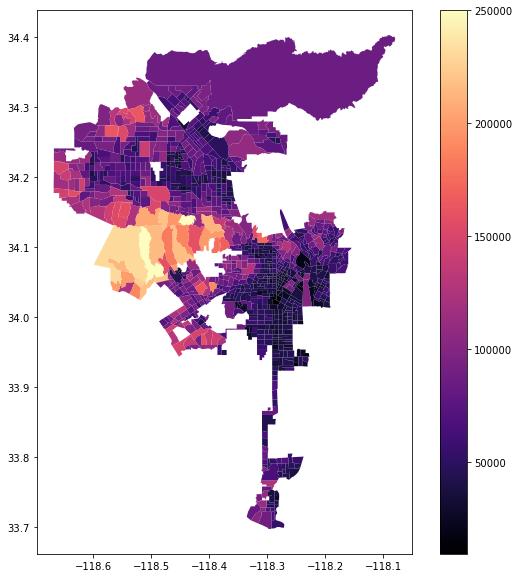

In [15]:
income.plot(figsize=(10,10), cmap='magma', column='median income', classification_kwds={'bins':[10,20,30,40,50,60,70,80,90,100]}, legend=True)


This map shows a correlation with car ridership in that the areas that have higher incomes overlap with those with high car ridership percentages. The reverse is true for bus ridership data. This is consistent with the research we've done that shows that in LA, those who commute by bus tend to have very low incomes. 

## Mapping the Bus Routes

Now that we have a better understanding of the landscape of commuter modes and income in LA, we want to explore what areas are being served by the bus. We'll map the existing bus route and the NextGen bus route which is in the process of being implemented in phases over the next few years. 

In [16]:
NextGen = gpd.read_file('data/200820_NextGen_Transit_First_DX15.shp')
ExRoute = gpd.read_file('data/Existing_Bus_System.shp')

We are using shape files provided by Metro on their website. 

Below is a map of the two networks. As you can see, the NextGen network has been paired down and some lines are being phased out. NextGen includes some increases in frequency along some lines. 

Text(0.5, 1.0, 'NextGen Bus Network')

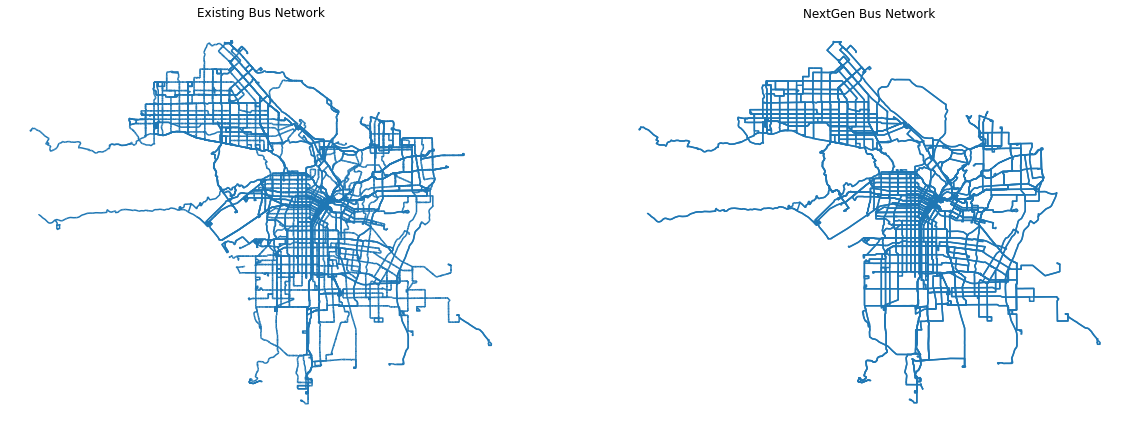

In [17]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 20))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
ExRoute.plot(ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Existing Bus Network")

# spatial lag map on the right
NextGen.plot(ax=ax2, # this assigns the map to the subplot,
            legend=True
           )

ax2.axis("off")
ax2.set_title("NextGen Bus Network")

Below we hoped to map one network on top of the other. We copied and pasted the code for this from Yoh's midterm feedback. We're not sure why but one cell : `ExRoute.crs` does not seem to be producing an output and then the map below it is getting an error. 

These two datasets are using coordinate systems, so in order to compare them directly, we have to reproject one on top of the other. 

In [18]:
NextGen.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
NextGen_web = NextGen.to_crs('epsg:3857')

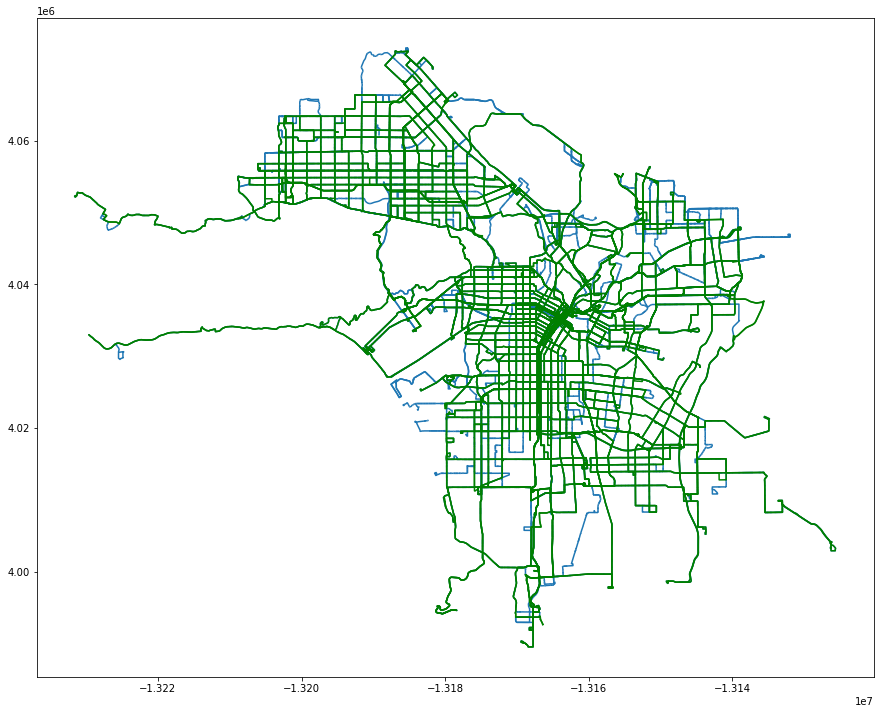

In [20]:
fig,ax = plt.subplots(figsize=(15,15))

ExRoute.plot(ax=ax)
NextGen_web.plot(ax=ax,color='g')


This map is the NextGen route projected on top of the current bus sytem. This shows more clearly where routes are being phased out. 

We can also explore frequency data for the existing bus network. Below, we've created a choropleth map of bus frequencies for the morning and evening commutes. Lower numbers mean buses come more often. 

In [21]:
ExRoute_am = ExRoute[ExRoute['ampk_1']!=0]
ExRoute_pm = ExRoute[ExRoute['pmpk_1']!=0]

Text(0.5, 1.0, 'Peak Evening Bus Frequency')

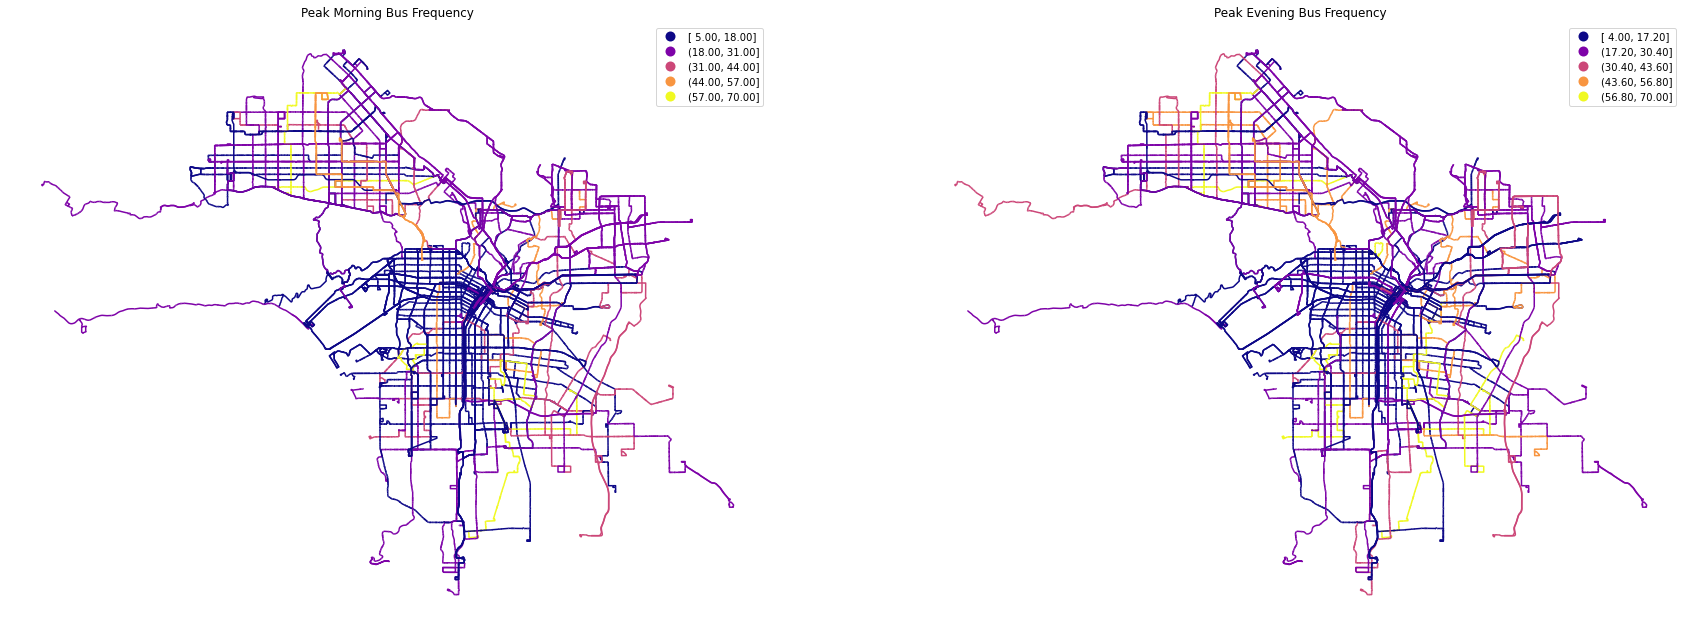

In [22]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(30, 30))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
ExRoute_am.plot(column='ampk_1', 
            cmap='plasma', 
            scheme='equal_interval',
            k=5, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Peak Morning Bus Frequency")

# spatial lag map on the right
ExRoute_pm.plot(column='pmpk_1', 
            cmap='plasma', 
            scheme='equal_interval',
            k=5,  
            ax=ax2, # this assigns the map to the subplot
            legend=True
           )

ax2.axis("off")
ax2.set_title("Peak Evening Bus Frequency")

Overall service across the network is more concentrated near downtown and frequent service also serves the downtown area during the morning and evening bus schedules. Service looks relatively similar in the morning and evening. It would be interesting to have information about direction. It's likely the buses are more frequently heading toward downtown in the morning and away from downtown at night. 

Continued...